In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

min distance to principle component

In [2]:
from sklearn.datasets import load_iris
np.random.seed(0)

iris = load_iris()
X = iris['data']
Y = iris['target']
DATA = np.concatenate((X, np.reshape(Y, (len(Y), 1))), axis=1)

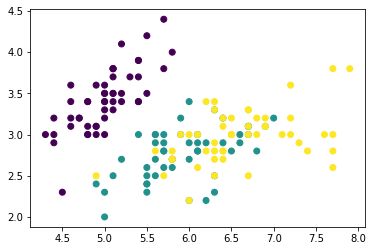

In [3]:
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [4]:
np.random.shuffle(DATA)
training_portion = 0.6

index = int(len(DATA) * 0.6)
TRAIN = DATA[:index, :]
TEST  = DATA[index:, :]

Xtrain, Ytrain = TRAIN[:, :-1], TRAIN[:, -1]
Xtest , Ytest  = TEST[:, :-1], TEST[:, -1]

## PCA

In [5]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
    
def pca_visualization_2d(X):
    """ visualize principal component of cluster """
    plt.scatter(X[:, 0], X[:, 1])
    plt.axis('equal');
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(X)
    print("variance:", pca.explained_variance_)
    print("std:", np.sqrt(pca.explained_variance_))
    print(pca.components_)
    


    # plot data
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length) # 3 std
        redv = vector * np.sqrt(length)  # 1 std
        draw_vector(pca.mean_, pca.mean_ + v)
        draw_vector(pca.mean_, pca.mean_ + redv)
    plt.axis('equal');

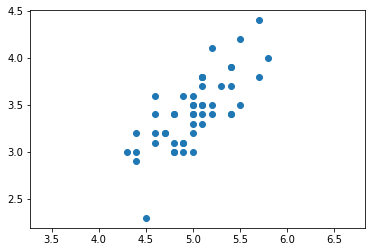

In [6]:
y=0
plt.scatter(X[:,0][Y==y], X[:,1][Y==y])
plt.axis('equal')
plt.show()

variance: [0.23366074 0.03427804]
std: [0.48338467 0.18514328]
[[ 0.67174957  0.74077832]
 [-0.74077832  0.67174957]]


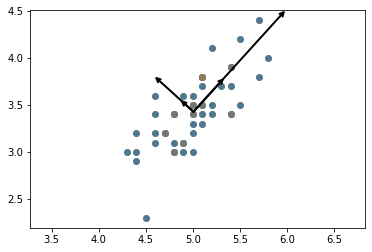

In [7]:
pca_visualization_2d(X[:,:2][Y==y])

## $U \Sigma V^{T} = X_{train}$
## $W = U \Sigma$

In [8]:
def svd_WVT(X):
    """ 
        X = U Sigma VT 
        W = U Sigma
        return W , VT
    """
    U,Sigma,VT = scipy.linalg.svd(X[Y==y])
    t = np.concatenate([Sigma, np.zeros((U.shape[0]-Sigma.shape[0],))], axis=0)
    Sc = np.diag(t)
    W = U.dot(Sc)
    VTc = np.concatenate([VT, np.zeros((U.shape[1]-VT.shape[0], VT.shape[1]))], axis=0)
    return W, VTc

(50, 50)


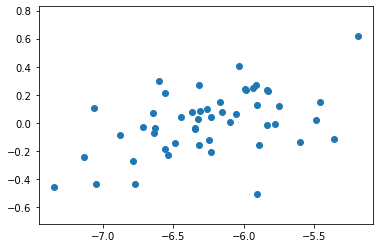

NameError: name 'VT' is not defined

In [9]:
# training

# U,Sigma,VT = scipy.linalg.svd(X[Y==y])
# print(U.shape, np.diag(Sigma).shape, VT.shape)
# t = np.concatenate([Sigma, np.zeros((U.shape[0]-Sigma.shape[0],))], axis=0)
# Sc = np.diag(t)
# W = U.dot(Sc)


W, VTc = svd_WVT(X)
print(W.shape)
plt.scatter(W[:,0], W[:,1])
plt.axis('equal')
plt.show()

# predicting

VTc = np.concatenate([VT, np.zeros((U.shape[1]-VT.shape[0], VT.shape[1]))], axis=0)
restored = W.dot(VTc)
plt.scatter(restored[:,0], restored[:,1])
plt.axis('equal')
plt.show()

print(U.shape, Sc.shape, VTc.shape)

## $W = X_{test} \ (V^{T})^{*}$

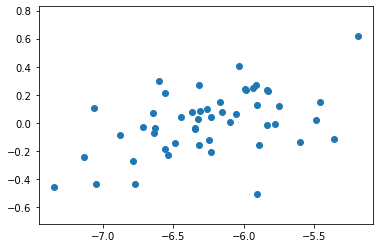

In [11]:
# predicting

invVTc = np.linalg.pinv(VTc)
Wcalced = X[Y==y].dot(invVTc)
plt.scatter(Wcalced[:,0], Wcalced[:,1])
plt.axis('equal')
plt.show()

In [12]:
invVTc.shape

(4, 50)

In [13]:
from numpy import array as arr
qwer=arr([[1,2,3,4,5],[1,7,8,9,0],[1,7,8,9,0]]) < arr([5,4,3,2,1])
np.sum(qwer, axis=0)

array([3, 1, 0, 0, 2])

In [14]:
def pvalue(X, test):
    """
        X: r by c
        test: 1 by c
        return: 1 by c
    """
    rawP = np.sum(X < test, axis=0) / X.shape[0]
    rawP[rawP>0.5] = 1-rawP[rawP>0.5]
    return rawP

[[-6.00007849 -0.06674139  1.62712836  0.08400561]]
mean [[5.006 3.428 1.462 0.246]]
pvalue: [[0.34 0.34 0.   0.18]]
pvalue mean: [[0.5  0.46 0.48 0.4 ]]


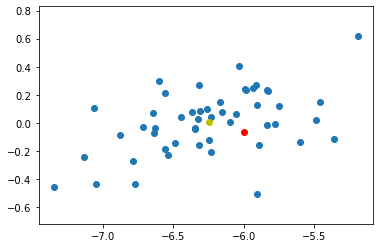

In [15]:
features=X.shape[1]
point = np.array([[5.5, 2.9, 0, 0]])
Wpoint = point.dot(invVTc)[:, :features]
print(Wpoint)
mean = np.array([np.mean(X[Y==y], axis=0)])
print("mean", mean)
Wmean = mean.dot(invVTc)[:, :features]


test = lambda data: pvalue(W[:,:X.shape[1]], data)
print("pvalue:", np.apply_along_axis(arr=Wpoint, axis=1, func1d=test))
print("pvalue mean:", np.apply_along_axis(arr=Wmean, axis=1, func1d=test))


plt.scatter(Wcalced[:,0], Wcalced[:,1])
plt.scatter(Wpoint[:,0], Wpoint[:,1], c='r')
plt.scatter(Wmean[:,0], Wmean[:,1], c='y')
plt.axis('equal')
plt.show()

point
[[-6.00007849e+00 -6.67413941e-02  1.62712836e+00  8.40056110e-02]
 [-6.24572780e+00  7.89703830e-03 -9.07867441e-06 -1.37161775e-03]]
pvalue: [[0.34 0.34 0.   0.18]
 [0.5  0.46 0.48 0.4 ]]


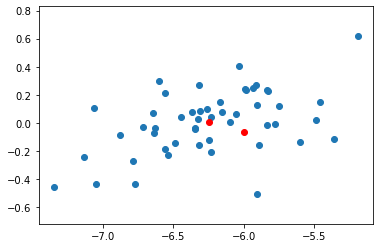

In [16]:
def pvalue_predict(point, c):
    features=X.shape[1]
    Wpoint = point.dot(invVTc)[:, :features]
    print(Wpoint)


    test = lambda data: pvalue(W[:,:X.shape[1]], data)
    print("pvalue:", np.apply_along_axis(arr=Wpoint, axis=1, func1d=test))

    plt.scatter(W[:,0], W[:,1])
    plt.scatter(Wpoint[:,0], Wpoint[:,1], c=c)
    plt.axis('equal')
    plt.show()
    
print("point")
pvalue_predict(np.array([[5.5, 2.9, 0, 0], np.mean(X[Y==y], axis=0)]), 'r')

In [85]:
invVTc.shape

(4, 50)

## copying and organizing the code from above

In [184]:
class PCA_pvalue:
    def __init__(self, Xtrain, Ytrain):
        """ X in Rn, Y in range(0,n) """
        self.features = Xtrain.shape[1]
        self.classes = np.array(np.unique(Ytrain), dtype='int')
        
        self.Ws  = []
        self.VTs = []
        self.invVTs = []
        
        for yi in self.classes:
            Wi, VTi = self.svd_WVT(Xtrain, Ytrain, yi)
            self.Ws.append(Wi)
            self.VTs.append(VTi)
            self.invVTs.append(np.linalg.pinv(VTi))
    
    @staticmethod
    def svd_WVT(X, Y, y):
        """ 
        X = U Sigma VT 
        W = U Sigma
        return W , VT
        """
        U,Sigma,VT = scipy.linalg.svd(X[Y==y])
        t = np.concatenate([Sigma, np.zeros((U.shape[0]-Sigma.shape[0],))], axis=0)
        Sc = np.diag(t)
        W = U.dot(Sc)
        VTc = np.concatenate([VT, np.zeros((U.shape[1]-VT.shape[0], VT.shape[1]))], axis=0)
        return W, VTc
    
    @staticmethod
    def empirical_pvalue(X, test):
        """
            X: r by c
            test: 1 by c
            return: 1 by c
        """
        rawP = np.sum(X < test, axis=0) / X.shape[0]
        rawP[rawP>0.5] = 1-rawP[rawP>0.5]
        return rawP
    
    def pvalue(self, Xtest):
        pv_yi = []
        
        for y in self.classes:
            # W, VT^-1
            W = self.Ws[y]
            invVT = self.invVTs[y]
            Wtest = Xtest.dot(invVT)[:, :self.features]
            
            print(Wtest)
            
            # features=X.shape[1]
            # point = np.array([[5.5, 2.9, 0, 0]])
            # Wpoint = point.dot(invVTc)[:, :self.features]
            # print(Wpoint)
            # mean = np.mean(X[Y==y], axis=0)
            # Wmean = mean.dot(invVTc)[:self.features]
            p_test = lambda data: self.empirical_pvalue(W[:,:self.features], data)
            pv_yi.append( np.apply_along_axis(arr=Wtest, axis=1, func1d=p_test) )
        return np.array(pv_yi)

In [185]:
pca_pvalue = PCA_pvalue(X, Y)
pca_pvalue.pvalue(np.array([np.mean(X, axis=0)]))

[[-7.28633155  1.74374645 -1.6239489   0.53320436]]
[[-7.66519448 -0.11083954  0.53334629 -0.02908371]]
[[-7.59148888 -0.26036652 -1.15293041 -0.15828236]]


array([[[0.02, 0.  , 0.  , 0.  ]],

       [[0.38, 0.42, 0.  , 0.4 ]],

       [[0.02, 0.22, 0.  , 0.22]]])